In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
qd.start_client("172.16.26.2")

In [8]:
default_config = qd.NVConfiguration()

default_config.test = True
default_config.mw_readout_channel = 1
default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 1200

default_config.adc_channel = 0 

default_config.mw_channel = 0
default_config.mw_nqz = 1
default_config.mw_gain = 5000
default_config.reps = 1

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 100 # between each rep, wait for everything to catch up, mostly aom


In [9]:
config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
on_value  = np.mean(data)
print('Approximate on intensity {} ADC units'.format(on_value))

prog = qd.LaserOff(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
off_value  = np.mean(data)
print('Approximate off intensity {} ADC units'.format(off_value))


Approximate on intensity 1837.8313725490195 ADC units
Approximate off intensity 18.84607843137255 ADC units


In [10]:
for i in range(2):
    
    qd.soc.clear_ddr4()

    config = copy(default_config)
    config.readout_integration_treg = 2**16 - 1

    config.mw_gain = 15000

    config.pre_init = False
    config.reps = 1
    config.relax_delay_treg = 100

    config.ddr4_channel = i

    config.add_linear_sweep('mw', 'fMHz', start=2700, stop=2800, delta=100)

    prog = qd.LockinODMR(config)
    d = prog.acquire(raw_data = True)

    if i == 0:
        laser_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)[:, 0]
    elif i == 1:
        mw_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)
        mw_real = mw_ddr4[:, 0]
        mw_imag = mw_ddr4[:, 1]


Requested 2700 to 2800 by 100
Instead using 2700.0 to 2799.99999961853 by 99.99999961853027 in 2 steps

Requested 2700 to 2800 by 100
Instead using 2700.0 to 2799.99999961853 by 99.99999961853027 in 2 steps


/var/folders/vj/6z72bnsn7b914qwrj1dr94p4002rr4/T/ipykernel_49367/3193559247.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  phase = np.arctan(np.mean(mw_real[300:800]) / np.mean(mw_imag[300:800]))


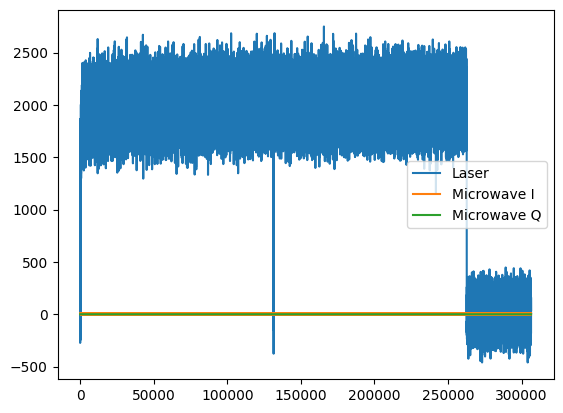

In [11]:
phase = np.arctan(np.mean(mw_real[300:800]) / np.mean(mw_imag[300:800]))
phase += np.pi/2

x = mw_real * np.cos(phase) - mw_imag * np.sin(phase)
y = mw_real * np.sin(phase) + mw_imag * np.cos(phase)

plt.plot(laser_ddr4, label='Laser')
plt.plot(mw_real, label='Microwave I')
plt.plot(mw_imag, label='Microwave Q')

plt.legend()

In [13]:
print(prog.asm())


// Program

                regwi 1, $22, 436906666;        //freq = 1747626667
                bitwi 1, $22, $22 << 2;
                mathi 1, $22, $22 + 3;
                regwi 1, $23, 0;                //phase = 0
                regwi 1, $25, 15000;            //gain = 15000
                regwi 1, $26, 655359;           //phrst| stdysel | mode | | outsel = 0b01001 | length = 65535 
                synci 100;
                regwi 0, $16, 8192;             //out = 0b0010000000000000
                seti 7, 0, $16, 0;              //ch =0 out = $16 @t = 0
                seti 7, 0, $0, 10;              //ch =0 out = 0 @t = 0
                synci 100;
                regwi 0, $13, 0;
                regwi 0, $14, 0;
LOOP_rep:       regwi 1, $22, 436906666;        //'gen1_freq' <= 1747626667 (2000.0000003814696 MHz)
                bitwi 1, $22, $22 << 2;
                mathi 1, $22, $22 + 3;
                regwi 0, $17, 1;
LOOP_gen1_freq: regwi 1, $27, 0;                //t = 